# Test Technique Descartes Underwriting - RAKOTONIAINA

L’objectif du projet est de construire un code structuré et fonctionnel en python.
Ce code doit permettre de faire une prédiction sur le jeu de données Auto
Insurance disponible sur https://www.kaggle.com/c/auto-insurance-fall-2017/data qui a
pour cible TARGET_FLAG. 

Ce notebook contient : 
- L'analyse exploratoire du jeu de données
- Feature Engineering pour préparer les données d'entrainement et de validation
- Entrainement de deux modèles et comparaison de la performance
- Prédiction sur le jeu de données test
- Conclusion

## Import

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score,make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import make_pipeline as make_pipeline_imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 

from xgboost import XGBClassifier
import re

import warnings
warnings.filterwarnings('ignore')

In [13]:
PATH_train_auto = r'auto-insurance-fall-2017/train_auto.csv'
PATH_test_auto = r'auto-insurance-fall-2017/test_auto.csv'

df= pd.read_csv(PATH_train_auto, index_col='INDEX')
df = df.drop(columns=['TARGET_AMT'])

## 1. Analyse Exploratoire des Données

Cette première partie nous permettra de prendre en main le jeu de données, de comprendre les différentes variables explicatives et de voir si des étapes de transformation des données seront nécessaires ou non. Elle permettra aussi d'émettre des premières hypothèses qui guideront le choix des modèles de Machine Learning à utiliser.

In [11]:
print("Taille du dataset : {}\n".format(df.shape[0]))
print("Variables Explicatives :\n", df.info())

Taille du dataset : 8161

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8161 entries, 1 to 10302
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   int64  
 1   KIDSDRIV     8161 non-null   int64  
 2   AGE          8155 non-null   float64
 3   HOMEKIDS     8161 non-null   int64  
 4   YOJ          7707 non-null   float64
 5   INCOME       7716 non-null   float64
 6   PARENT1      8161 non-null   object 
 7   HOME_VAL     7697 non-null   float64
 8   MSTATUS      8161 non-null   object 
 9   SEX          8161 non-null   object 
 10  EDUCATION    8161 non-null   object 
 11  JOB          7635 non-null   object 
 12  TRAVTIME     8161 non-null   int64  
 13  CAR_USE      8161 non-null   object 
 14  BLUEBOOK     8161 non-null   float64
 15  TIF          8161 non-null   int64  
 16  CAR_TYPE     8161 non-null   object 
 17  RED_CAR      8161 non-null   object 
 18  OLDCLAIM     8161 non

Le jeu de données est composé d'un échantillon de 8161 individus avec 23 variables explicatives. Il possède des variables continues ainsi que des variables catégorielles. Nous remarquons que certaines variables (INCOME, BLUEBOOK, OLD_CLAIM) qui devraient mentionner un montant est considéré comme string. Une première étape de pré-processing est alors nécessaire à ce stade.


In [14]:
def cast_to_num(data, cols):
    for column in cols:
        data[column] = data[column].str.replace('$','',regex=False).str.replace(',','.',regex=False).astype('float')
    
    return data

string_col = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']
df = cast_to_num(df, string_col)

In [15]:
df.describe()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE
count,8161.000000,8161.000000,8155.000000,8161.000000,7707.000000,7716.000000,7697.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,7651.000000
mean,0.263816,0.171057,44.790313,0.721235,10.499286,64.757855,154.867290,33.485725,15.709900,5.351305,13.313173,0.798554,1.695503,8.328323
std,0.440728,0.511534,8.627589,1.116323,4.092474,60.768449,129.123775,15.908333,8.419734,4.146635,85.538813,1.158453,2.147112,5.700742
min,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.500000,1.000000,0.000000,0.000000,0.000000,-3.000000
25%,0.000000,0.000000,39.000000,0.000000,9.000000,28.696250,0.000000,22.000000,9.280000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,45.000000,0.000000,11.000000,54.799500,161.160000,33.000000,14.440000,4.000000,0.000000,0.000000,1.000000,8.000000
75%,1.000000,0.000000,51.000000,1.000000,13.000000,87.259000,238.724000,44.000000,20.850000,7.000000,4.906000,2.000000,3.000000,12.000000
max,1.000000,4.000000,81.000000,5.000000,23.000000,997.000000,885.282000,142.000000,69.740000,25.000000,999.000000,5.000000,13.000000,28.000000


A ce stade, nous n'avons pas encore une vision claire des sens des variables ainsi que leur importance. L'analyse exploratoire se déroulera comme suit :
- Détermination des valeurs manquantes
- Distribution des classes
- Distribution des variables explicatives ( catégorielles et numériques) 

#### Valeurs manquantes :

In [17]:
print("Nombres de valeurs manquantes : {}\n ".format(df.isnull().sum().sum()))
df_dropna = df.dropna()
print("Proportion NAN / TOTAL : {} %".format(((df.shape[0] - df_dropna.shape[0]) / df.shape[0]) * 100))

Nombres de valeurs manquantes : 2405
 
Proportion NAN / TOTAL : 25.928195074133072 %


#### Distribution de la variable target :

Proportion de la cible positive : 0.2638157088592084


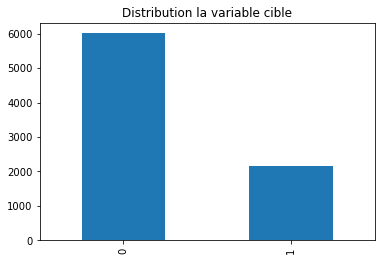

In [19]:
plt.title('Distribution la variable cible')
df['TARGET_FLAG'].value_counts().plot(kind="bar")

print("Proportion de la cible positive : {}".format(df['TARGET_FLAG'].mean()))

#### Distribution des variables explicatives : 

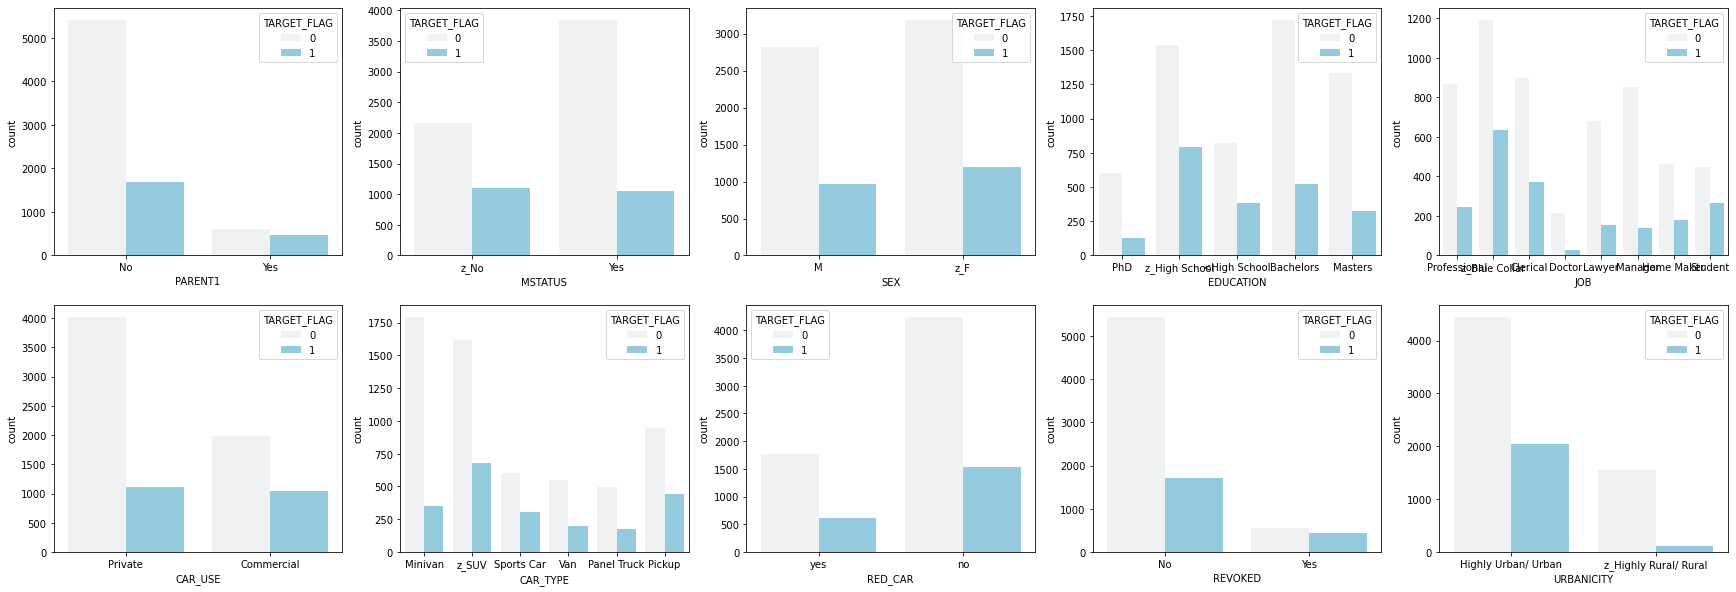

In [20]:
numerical_features = [col for col in df.columns if df[col].dtype != object]
categorical_features = [col for col in df.columns if df[col].dtype == object]

f, axes = plt.subplots(2, 5, figsize=(30, 10))
for ax, variable in zip(axes.flat,categorical_features):
    sns.countplot(x=variable, data=df, ax = ax,color="skyblue", hue="TARGET_FLAG")

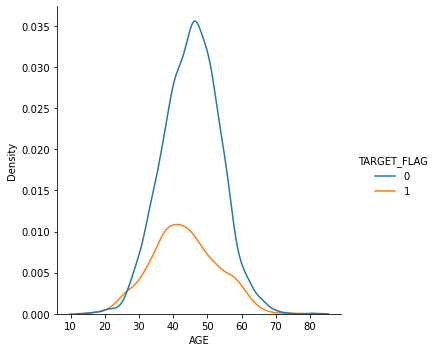

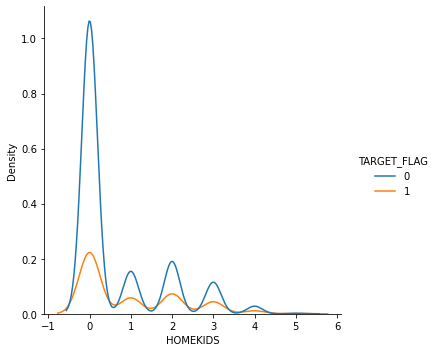

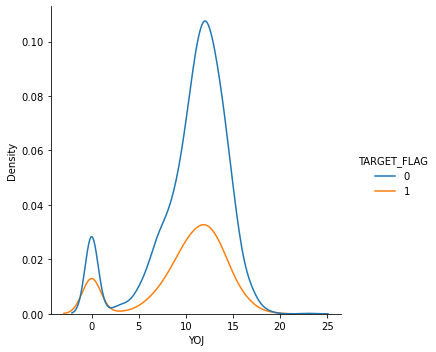

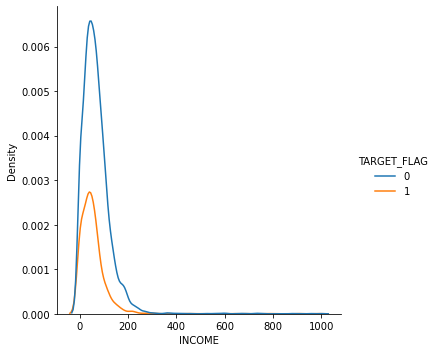

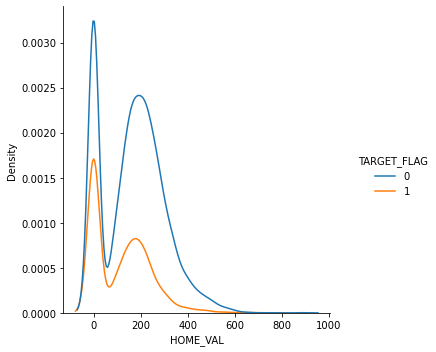

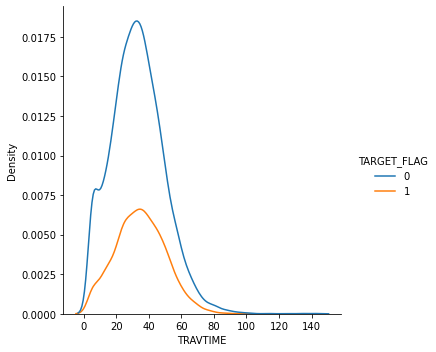

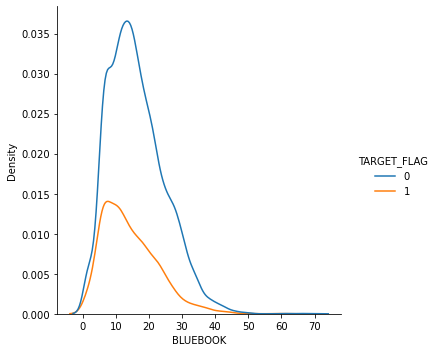

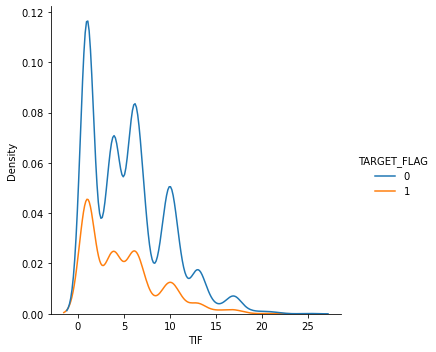

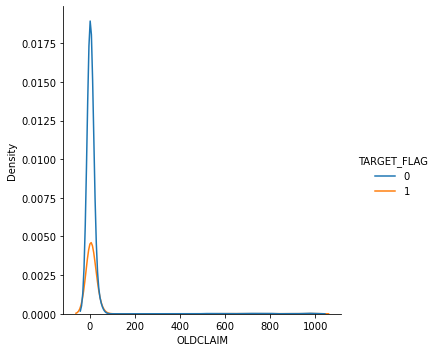

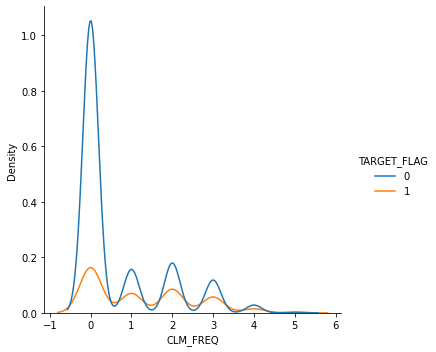

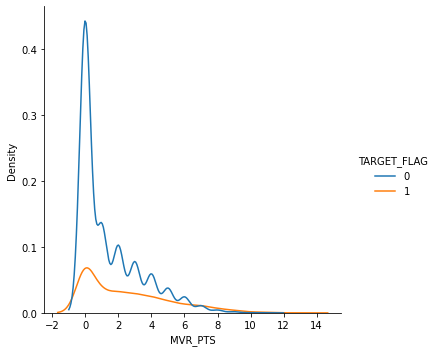

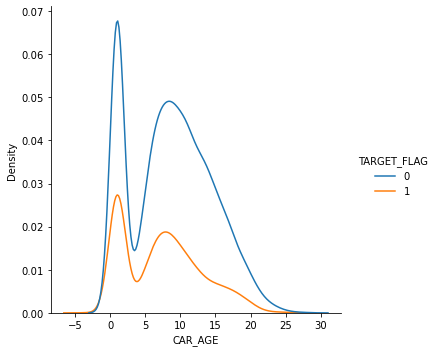

In [21]:
for i in numerical_features[2:]:
    sns.displot(x=i, data=df, hue='TARGET_FLAG', kind='kde')

#### Premières conclusions : 
- Notre jeu de données est composé de 13 variables numériques et 10 variables catégorielles dont 3 variables possèdent plus de deux catégories. Des transformations seront nécessaires pour encoder les variables catégorielles. 
- Le jeu de données contient une quantité pas négligeable de valeurs manquantes. Deux solutions peuvent être envisageables : supprimer les individus contenant les valeurs manquantes qui induirait à une réduction de l'échantillon mais permettrait d'avoir les vraies valeurs ; remplacer les valeurs manquantes par la médiane des valeurs ou la catégorie majoritaire qui pourrait biaiser notre jeu de données avec des données synthétiques.
- Notre jeu de données fait face à un problème de déséquilibre de classe. Seulement 26% du jeu de données sont de la classe positive. Nous allons utiliser des modèles de type "ensemble" pour remédier à cela et une deuxième méthode est alors de "up-sampler" la classe minoritaire en générant des données synthétique. 
- Quant aux variables catégorielles, la proportion et distribution des variables suivent le déséquilibre de classe que nous avons évoqué précédemment. Nous ne voyons pas de tendance marquante sur les variables. 
- Concernant les variables numériques, les variables explicatives de la classe 0 et classe 1 semblent avoir les mêmes distributions. Il n'y existe pas une réelle séparation de la distribution. 

Nous choisirons des modèles de type arbre de décisions et de type ensemble car nous avons une quantité pas très élevée de données.


## 2. Features Engineering

Les étapes de features engineering intégrées dans la classe **processData** sont: 
- encoder les variables catégorielles avec la méthode One hot Encoding. 
- remplir les valeurs manquantes en utilisant la médiane ou la catégorie majoritaire. 
- normaliser les valeurs numériques. 
- encoder les variables booléeenes avec la méthode Ordinal Encoder pour éviter de créer un features pour chaque valeur.
- Mettre de côté 20 % du jeu de données comme jeu de validation.

In [23]:
class processData:
    
    def __init__(self, num_features, bin_features, cat_features):
        self.num_features = num_features
        self.bin_features = bin_features
        self.cat_features = cat_features
    
    def cast_to_num(self, data):
        string_col = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']
        for column in string_col:
            data[column] = data[column].str.replace('$','',regex=False).str.replace(',','.',regex=False).astype('float')

        return data

    def fillna(self, data, num_features, bin_features, cat_features):
        for num in num_features:
            data[num].fillna(data[num].median(), inplace=True)
            
        for feature in bin_features:
            majority = data[feature].value_counts().index.tolist()[0]
            data[feature].fillna(majority, inplace = True)
        
        for cat in cat_features:
            majority = data[cat].value_counts().index.tolist()[0]
            data[cat].fillna(majority, inplace=True)
        
        return data
    
    def scale(self, data, num_features):
        for num in num_features:
            scaler = preprocessing.StandardScaler()
            data[num] = scaler.fit_transform(data[[num]])
        
        return data
    
    def OneHotEncode(self, data, cat_features):
        new_data = pd.get_dummies(data, columns=cat_features, sparse=True)
        
        return new_data
    
    def OrdEncode(self, data, bin_features):
        for feat in bin_features:
            ord_enc = preprocessing.OrdinalEncoder()
            data[feat] = ord_enc.fit_transform(data[[feat]])
        
        return data
    
    def transform(self, data):
        X, y = data.drop(columns=['TARGET_FLAG', 'TARGET_AMT']), data['TARGET_FLAG']
        
        X = self.cast_to_num(X)
        X = self.fillna(X, self.num_features, self.bin_features, self.cat_features)
        X = self.scale(X, self.num_features)
        X = self.OrdEncode(X, self.bin_features)
        X = self.OneHotEncode(X, self.cat_features)
        
        return X, y

In [24]:
df_train = df= pd.read_csv(PATH_train_auto, index_col='INDEX')

num_features = [
 'KIDSDRIV',
 'AGE',
 'HOMEKIDS',
 'YOJ',
 'INCOME',
 'HOME_VAL',
 'TRAVTIME',
 'BLUEBOOK',
 'TIF',
 'OLDCLAIM',
 'CLM_FREQ',
 'MVR_PTS',
 'CAR_AGE'
]

categorical_features = [i for i in df_train.drop(columns=['TARGET_FLAG', 'TARGET_AMT']) if i not in num_features]

cat_features = ['EDUCATION', 'JOB', 'CAR_TYPE']
bin_features = [i for i in categorical_features if i not in cat_features]

In [25]:
train_process = processData(num_features=num_features, bin_features=bin_features, cat_features=cat_features)
X, y = train_process.transform(df_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

## 3. Entrainement des modèles

### Métriques : 

Nous sommes dans un cadre de classification binaire. Plusieurs métriques peuvent être utilisés et cela en fonction du besoin métier:
- **Accuracy :** La proportion de bonne prédiction sur l'ensemble total de cas. L'utilisation de cette métrique n'est pas très pertinente dans notre cas où le déséquilibre de classe est flagrant. Nous pourrons utiliser **Balanced_accuracy** métrique pour remédier à cela.
- **Precision :** La proportion de vrai positif sur l'ensemble de prédiction positive.
- **Recall :** La proportion de vrai positif sur l'ensemble des cas réellement positif. 
- **f1_score :** Le compromis entre Precision et Recall.

Le choix des métriques sera déterminé en fonction des cas d'usage s'il est plus couteux de faire des erreurs de prédiction sur la classe positive ou sur la classe négative. Dans notre cas, nous allons étudier les différents métriques à des fins de comparaison et choisir le modèle ayant un score f1 le plus élevé pour la prédiction du jeu de données test.

In [26]:
def recap_metrics(y_true, y_pred, model):
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    recap = pd.DataFrame(columns=['modele', 'accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1_score'])
    recap.loc[0,'modele'] = model
    recap.loc[0,'accuracy'] = accuracy
    recap.loc[0,'balanced_accuracy'] = balanced_accuracy
    recap.loc[0,'precision'] = precision
    recap.loc[0,'recall'] = recall
    recap.loc[0,'f1_score'] = f1
    
    return recap

Dans cette étude de cas, nous allons tester deux modèles d'ensemblistes:
- un premier basé sur de l'aggrégation qui est le Random Forest
- un deuxième modèle d'ensemble boosté qui est l'XGBoost. 


Dans cette première partie de l'entrainement, nous allons garder le jeu de données telle quelle avec la présence de déséquilibre des classes. Nous allons effectuer une optimisation pour déterminer les paramètres optimaux avec une méthode de cross validation. Cette recherche d'hyperparamètre sera par la suite affinée dans une seconde partie pour le modèle le plus performant.

### Random Forest : 

In [27]:
clf_Rf = RandomForestClassifier(n_jobs=-1)

param_grid = {
"n_estimators": np.arange(100, 1500, 100),
"max_depth": np.arange(1, 31),
"criterion": ["gini", "entropy"]
}


model = RandomizedSearchCV(
    estimator=clf_Rf,
    param_distributions=param_grid,
    scoring='f1',
    verbose=0,
    n_jobs=-1,
    cv=5,
    n_iter=20
)

model.fit(X_train, y_train)

print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")
    
y_pred = model.predict(X_test)
rf_recap = recap_metrics(y_test, y_pred, 'Random Forest')

Best parameters set:
	criterion: entropy
	max_depth: 22
	n_estimators: 600


### XGBoost Classifier

In [28]:
clf_xgb = XGBClassifier(learning_rate=1e-3, 
                        n_estimators=1000, 
                        objective='binary:logistic',
                        silent=True,
                        tree_method='gpu_hist')

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }


model = RandomizedSearchCV(
    estimator=clf_xgb,
    param_distributions=params,
    scoring='f1',
    verbose=0,
    n_jobs=-1,
    cv=5,
    n_iter=10
)

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

xgb_recap = recap_metrics(y_test, y_pred, 'XGBOOST Classifier')

[22:18:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:18:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
recap_merge=pd.concat([xgb_recap,rf_recap],axis=0)
recap_merge

,modele,accuracy,balanced_accuracy,precision,recall,f1_score
0,XGBOOST Classifier,0.766075,0.603689,0.696203,0.247748,0.365449
0,Random Forest,0.793631,0.662126,0.737778,0.373874,0.496263


Pour les deux modèles, on remarque une différence très notable entre l'accuracy et le balanced accuracy mais aussi entre la précision et le recall. Ceci peut être causé par le déséquilibre de classe qu'on a évoqué précédemment. 

Nous pouvons voir ci-dessus le récapitulatif de performance des deux modèles. Sur ce résultat, on peut voir qu un modèle ensembliste boosté semble moins performant que le Random Forest. Ceci peut être dû à des hyperparamètres non appropriés durant l'étape de cross validation. 

En effectuant le ré-équilibrage des classes, nous allons nous concentrer sur le modèle Random Forest. Nous ferons dans un premier temps un undersampling ce qui induirait à une réduction importante de notre jeu de données, puis un oversampling.

### Ré-équilibrage des classes 

In [30]:
rus = RandomUnderSampler(random_state=42)
ros = RandomOverSampler(random_state=42)

X_under, y_under = rus.fit_resample(X_train, y_train)
X_over, y_over = ros.fit_resample(X_train, y_train)

In [31]:
def train_test_model(model_name, param, X_train, y_train, X_test, y_test):
    classifier = RandomForestClassifier(n_jobs=-1)
    
    model = GridSearchCV(
        estimator=classifier,
        param_grid=param,
        scoring="f1",
        verbose=0,
        n_jobs=-1,
        cv=5
    )
    
    model.fit(X_train, y_train)
    
    best_parameters = model.best_estimator_.get_params()
    print("best param for {}\n".format(model_name))
    for param_name in sorted(param_grid.keys()):   
        print(f"\t{param_name}: {best_parameters[param_name]}")
    
    y_pred = model.predict(X_test)
    
    recap = recap_metrics(y_test, y_pred, model_name)
    
    return model, recap

In [33]:
param_grid = {
"n_estimators": [400,600, 800],
"max_depth": [24,26,28],
}

rf_over , recap_over = train_test_model("Rf_over", param_grid, X_over, y_over, X_test, y_test)
rf_under, recap_under = train_test_model("Rf_under", param_grid, X_under, y_under, X_test, y_test)

final_recap = pd.concat([recap_over, recap_under],axis=0)

best param for Rf_over

	max_depth: 28
	n_estimators: 600
best param for Rf_under

	max_depth: 26
	n_estimators: 600


In [34]:
final_recap

,modele,accuracy,balanced_accuracy,precision,recall,f1_score
0,Rf_over,0.792407,0.696565,0.66055,0.486486,0.560311
0,Rf_under,0.714023,0.727411,0.483453,0.756757,0.589991


Nous voyons ici un score f1 plus élevé en rééquilibrant notre jeu de données. Si faire une erreur sur la prédiction de la classe négative est plus coûteux, alors on choisira le modèle ayant une précision plus élevée et inversement si faire une erreur sur la prédiction de la classe positive est plus couteux, alors on choisira le modèle ayant un recall plus élevée. 
Seul le métier déterminera le choix des modèles en fonction des cas d'usage et du côut. Dans notre étude, nous prendrons le modèle ayant un score f1 plus élevé qui est compromis entre les deux.

## 4. Prédiction jeu de données test

In [43]:
df_test = df= pd.read_csv(PATH_test_auto, index_col='INDEX')
test_process = processData(num_features=num_features, bin_features=bin_features, cat_features=cat_features)

X_test, _ = train_process.transform(df_test)
X_test.shape

(2141, 39)

In [44]:
pred_test = rf_under.predict(X_test)
pred_test.shape

(2141,)

In [48]:
pd.DataFrame(pred_test).to_csv('prediction.csv', sep=',',index=False)

## 5. Conclusion

Nous avons pu entrainer un modèle avec un score f1 = 0.58 avec un jeu de données initial très déséquilibré. En perspective d'amélioration, nous pourrions nous concentrer sur les variables explicatives c'est-à-dire améliorer le remplacement des valeurs manquantes par d'autres méthodes plus poussées. Aussi, nous aurions pu effectuer des sélections de variables et création de nouvelles variables qui pourraient être intéressantes qui réduiraient la dimension de notre jeu de données. 